In [1]:
from models import model_softm, model_diri
from utils import *
import torch.multiprocessing as mp
import torch.optim as optim 

import torchvision
from torchvision import datasets, transforms

import math

mnist_trainset = datasets.MNIST(root='./data_train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
mnist_testset = datasets.MNIST(root='./data_test', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))


In [13]:
torch.manual_seed(0)
world_size = 2
mp.spawn(
    runmain,
    args=[model_diri, mnist_trainset, mnist_testset, world_size, 5],
    nprocs=world_size
)


[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:401] [c10d] The server socket cannot be initialized on [::]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
[W socket.cpp:558] [c10d] The client socket cannot be initialized to connect to [localhost]:29500 (errno: 97 - Address family not supported by protocol).
/scratch365/kho2/models.py:13: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /tmpscratch/kho2/.cache/torch/kernels. This warning will appear only once per process. (Triggere

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.138802
Train Epoch: 1 [3200/60000 (11%)]	Loss: 1.978031
Train Epoch: 1 [6400/60000 (21%)]	Loss: 1.951569
Train Epoch: 1 [9600/60000 (32%)]	Loss: 1.977231
Train Epoch: 1 [12800/60000 (43%)]	Loss: 1.816843
Train Epoch: 1 [16000/60000 (53%)]	Loss: 1.661142
Train Epoch: 1 [19200/60000 (64%)]	Loss: 1.414104
Train Epoch: 1 [22400/60000 (75%)]	Loss: 1.325717
Train Epoch: 1 [25600/60000 (85%)]	Loss: 1.091802
Train Epoch: 1 [28800/60000 (96%)]	Loss: 1.194755
Test average loss: 0.36063359375, correct predictons: 8064, total: 10000, accuracy: 80.64% 

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.067925
Train Epoch: 2 [3200/60000 (11%)]	Loss: 1.081071
Train Epoch: 2 [6400/60000 (21%)]	Loss: 1.053558
Train Epoch: 2 [9600/60000 (32%)]	Loss: 0.889911
Train Epoch: 2 [12800/60000 (43%)]	Loss: 0.889334
Train Epoch: 2 [16000/60000 (53%)]	Loss: 1.146133
Train Epoch: 2 [19200/60000 (64%)]	Loss: 0.936764
Train Epoch: 2 [22400/60000 (75%)]	Loss: 0.477663
Train Epoch: 2 [25600/6

In [14]:
#Check test samples accuracy
import torch
network = model_diri()
network.load_state_dict(torch.load('model_diri_clip.pt'), strict=False)
network.eval()

all_mnist_testset = torch.unsqueeze(mnist_testset.data, 1).float()

output = network(all_mnist_testset).data + 1
pred = output.max(1, keepdim=True)[1].flatten()
 
S = torch.sum(output, 1, keepdim=True)
b = output/S
u = 10/S

correct_mask = (mnist_testset.targets == pred)
sum(correct_mask).item()/len(correct_mask)

0.9478

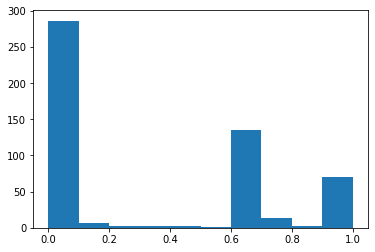

In [15]:
import matplotlib.pyplot as plt
plt.hist(u[~correct_mask].flatten().numpy())
plt.show() 

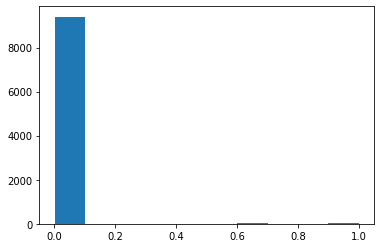

In [16]:
import matplotlib.pyplot as plt
plt.hist(u[correct_mask].flatten().numpy())
plt.show() 

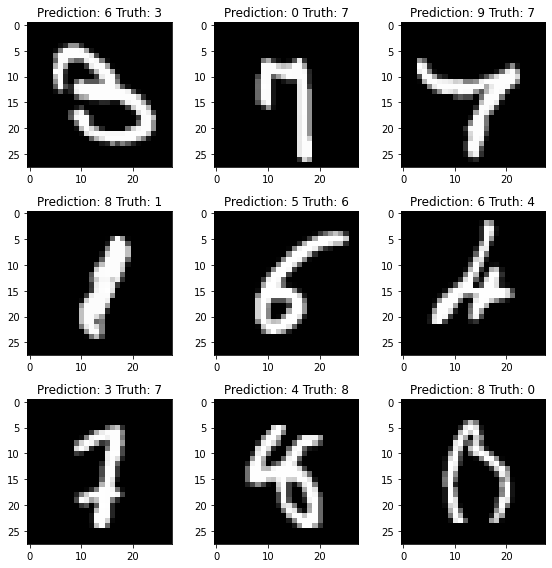

In [41]:
#Looking at some wrong examples
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
for i, (example_data, example_targets) in enumerate(zip(mnist_testset.data[~correct_mask], mnist_testset.targets[~correct_mask])):
        example_data = example_data.unsqueeze_(0).float()
        if i >= 3*3: break
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data.permute(1, 2, 0), cmap='gray')
        with torch.no_grad():
            prediction = network(example_data).data.max(1, keepdim=True)[1].item()
            plt.title("Prediction: {} Truth: {}".format(prediction, example_targets, fontsize=18))

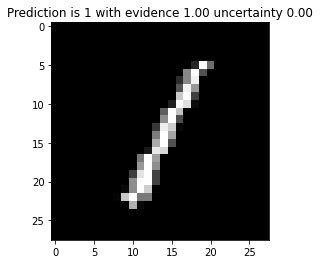

In [72]:
from IPython import display
import time
evidence, unc, angles, rotated_pics = [], [], [], []
for angle in range(10, 360, 10):
    example_data_rotated = transforms.functional.rotate(digi_one, angle=angle)
    plt.imshow(example_data_rotated.permute(1, 2, 0), cmap='gray')
    

    output = network(example_data_rotated).data + 1
    pred = output.max(1, keepdim=True)[1].flatten()
    S = torch.sum(output, 1, keepdim=True)
    b = output/S
    u = 10/S

    plt.title(f'Prediction is {pred.item()} with evidence {b.max().flatten().item():0.2f} uncertainty {u.flatten().item():0.2f}')
    
    
    evidence.append(b.max().flatten().item())
    unc.append(u.flatten().item())
    angles.append(angle)
    rotated_pics.append(example_data_rotated)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(.1)

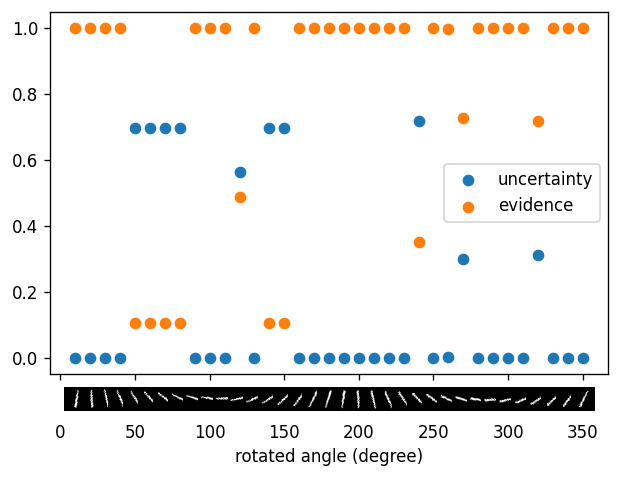

In [118]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def offset_image(coord, index, ax):
    im = OffsetImage(rotated_pics[index].permute(1, 2, 0), zoom=0.5, cmap='gray')
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, -0.025),  xybox=(0., -20.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
ax.scatter(angles, unc, label='uncertainty')
ax.scatter(angles, evidence, label='evidence')
ax.tick_params(axis='x', which='major', pad=26)
for i, c in enumerate(range(10, 360, 10)):
    offset_image(c, i, ax)
ax.set_xlabel('rotated angle (degree)')
ax.legend()
plt.show()